In [2]:
import sys, os, pickle
import torch
sys.path.append('/home/om2382/mft-theory/')
from cluster import *
from core import *
from empirics import *
from functions import *
from ode_methods import *
from plotting import *
from theory import *
from utils import *
from functools import partial
import matplotlib.pyplot as plt

In [3]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
mode = 'theory' #or 'theory'
if mode == 'theory':
    n_seeds = 1
    macro_configs = config_generator()
if mode == 'sim':
    n_seeds = 10
    macro_configs = config_generator()

micro_configs = tuple(product(macro_configs, list(range(n_seeds))))
prototype = False

### --- SELECT PARTICULAR CONFIG --- ###
try:
    i_job = int(os.environ['SLURM_ARRAY_TASK_ID']) - 1
except KeyError:
    i_job = 0
    prototype = True
params, i_seed = micro_configs[i_job]
i_config = i_job//n_seeds

new_random_seed_per_condition = True
if new_random_seed_per_condition:
    np.random.seed(i_job)
else: #Match random seeds across conditions
    np.random.seed(i_seed)

In [9]:
### --- Set empirical parameters --- ###

#network properties size
N = 4000
g = 6
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
T_lag = 50
dT_lag = 0.5
lags = np.arange(0, 50, dT_lag)

In [8]:
np.random.seed(0)
W = np.random.normal(0, g/np.sqrt(N), (N, N))
W_ = torch.from_numpy(W).type(torch.FloatTensor).to(0)

In [53]:
### --- Estimate cov empirically --- ###
r_cov = estimate_Psi_with_on_diagonals(lags=[0], T_sim=1000, dt_save=1, dt=0.05, W=W_, phi_torch=phi_torch,
                                       T_save_delay=500, N_batch=1, N_loops=60, runga_kutta=True,
                                       noise_sigma=0, mode='tau_tau', return_raw_cov=True)

r_cov = np.squeeze(r_cov.cpu().detach().numpy())

Psi_emp = estimate_Psi_with_on_diagonals(lags=lags, T_sim=1000, dt_save=dT_lag, dt=0.05, W=W_, phi_torch=phi_torch,
                                         T_save_delay=500, N_batch=1, N_loops=60, runga_kutta=True,
                                         noise_sigma=0, mode='tau_0', return_raw_cov=False)
Psi_emp = np.squeeze(Psi_emp.cpu().detach().numpy())

In [11]:
### --- Compute C_emp for single units --- ###
x, r = sample_activity(T_sim=5000, dt_save=dT_lag, dt=0.05, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=1000)
r = torch.from_numpy(r).type(torch.FloatTensor).to(0)[:,None,:]
C_emp = compute_lagged_xcov(r, r, lags, dt_save=dT_lag)

#symmetrize C_emp for comparison
C_emp = C_emp.cpu().detach().numpy().squeeze().mean(-1)

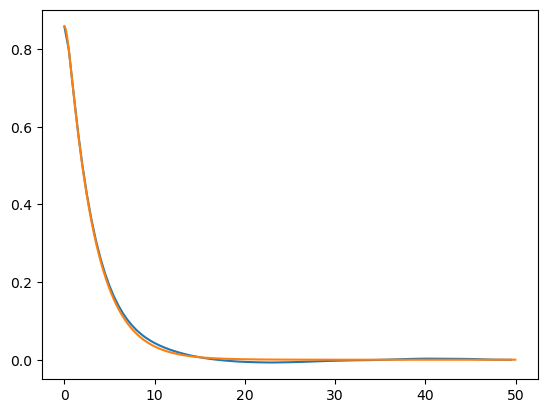

In [15]:
lags_theory = np.arange(0, T_lag, dT)
plt.plot(lags, C_emp)
plt.plot(lags_theory, C_phi_half[:len(lags_theory)])

In [16]:
single_unit_result = {}
single_unit_result['theory_C'] = C_phi_half
single_unit_result['empirical_C'] = C_emp
single_unit_result['dT_emp'] = dT_lag
single_unit_result['dT_theory'] = dT
with open('packaged_results/Psi_PC_single_unit', 'wb') as f:
    pickle.dump(single_unit_result, f)

In [54]:
eigs, vecs = np.linalg.eig(r_cov)

In [55]:
acovs = np.zeros((len(lags), N))
N_loops = 100
for i_loop in range(N_loops):
    x, r = sample_activity(T_sim=2000, dt_save=dT_lag, dt=0.05, W=W_, phi_torch=phi_torch,
                           T_save_delay=500, N_batch=1, runga_kutta=True, noise_sigma=0)
    
    PCs = r.dot(vecs)
    PCs = torch.from_numpy(PCs).type(torch.FloatTensor).to(0)
    PCs = PCs[:,None,:]
    acov_ = compute_lagged_xcov(PCs, PCs, lags, dT_lag, outer=False)
    acovs +=  acov_.cpu().detach().numpy().squeeze() / N_loops

In [13]:
### --- Set theory parameters --- ###
T_window = 200
dT = 0.025

In [14]:
### --- Compute single-unit properties

d = compute_Delta_0(g=g)
time, Delta_T = integrate_potential(d, g=g, tau_max=T_window, N_tau=int(T_window/dT))
Delta_T = fix(Delta_T)
C_phi_half = compute_C_simple(d, Delta_T)
avg_gain = compute_phi_prime_avg(d)

In [84]:
### --- Compute Psi from theory --- ###

#Define relevant single-unit functions
C_phi = np.concatenate([C_phi_half,
                        np.array([C_phi_half[-1]]),
                        C_phi_half[1:][::-1]])
C_phi_omega = fft(C_phi, dT)
T = len(C_phi)
t_indices= np.concatenate([np.arange(0, T//2), np.arange(-T//2, 0)])
sampfreq = 1/dT
w = 2*np.pi*sampfreq*t_indices/T
C_phi_C_phi = np.multiply.outer(C_phi_omega, C_phi_omega)
S_phi = avg_gain/(np.sqrt(2*np.pi)*(1 + 1j*w))
S_phi_S_phi = np.multiply.outer(S_phi, S_phi)


#Compute psi of normalized units for LDRG network
num = 1
denom = np.abs(1 - 2*np.pi*g**2 * S_phi_S_phi)**2
Psi_omega1_omega2 = (num / denom) * C_phi_C_phi
Psi_tau1_tau2 = ifft(Psi_omega1_omega2, dT)
Psi_tau_0 = Psi_tau1_tau2[:,0].real

In [ ]:
#example traces
x, r = sample_activity(T_sim=3000, dt_save=0.05, dt=0.05, W=W_, phi_torch=phi_torch,
                       T_save_delay=2000, N_batch=1, runga_kutta=True, noise_sigma=0)

PCs = r.dot(vecs)

In [88]:
data = {'theory_Psi': Psi_tau_0, 'dT_theory': dT,
        'empirical_acovs': acovs, 'empirical_Psi': Psi_emp, 'dT_emp': dT_lag,
        'eigs': eigs, 'ex_traces': PCs}

In [ ]:
### --- SAVE RESULTS -- ###
result = {'sim': None, 'i_seed': i_seed, 'config': params,
          'i_config': i_config, 'i_job': i_job, 'data': data}
try:
    result['processed_data'] = processed_data
except NameError:
    pass
    
try:
    save_dir = os.environ['SAVEDIR']
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_path = os.path.join(save_dir, 'result_{}'.format(i_job))

    with open(save_path, 'wb') as f:
        pickle.dump(result, f)
except KeyError:
    pass

In [3]:
###Truncate file above
file_name = 'Psi_PC_avg_timescales'
job_name = 'Psi_PC_theory_sim'
project_dir = '/home/om2382/low-rank-dims/'
main_script_path = os.path.join(project_dir, 'cluster_main_scripts', job_name + '.py')
get_ipython().run_cell_magic('javascript', '', 'IPython.notebook.save_notebook()')
get_ipython().system('jupyter nbconvert --to script --no-prompt {}.ipynb'.format(file_name))
get_ipython().system('awk "/###Truncate/ {{exit}} {{print}}" {}.py'.format(file_name))
get_ipython().system('sed -i "/###Truncate/Q" {}.py'.format(file_name))
get_ipython().system('mv {}.py {}'.format(file_name, main_script_path))

<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook Psi_PC_avg_timescales.ipynb to script
[NbConvertApp] Writing 12790 bytes to Psi_PC_avg_timescales.py
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2b8c641e5490> <built-in function print>
awk: cmd. line:1:                       ^ syntax error
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2b8c641e5490> <built-in function print>
awk: cmd. line:1:                                                                                ^ syntax error


In [4]:
###Submit job to cluster
n_jobs = len(micro_configs)
write_job_file(job_name, py_file_name='{}.py'.format(job_name),
               mem=64, n_hours=24, n_gpus=1,
               results_subdir='PRL_Submission')
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
submit_job(job_script_path, n_jobs, execute=False, results_subdir='PRL_Submission', lkumar=False)

rm: cannot remove ‘/home/om2382/low-rank-dims/results/PRL_Submission/Psi_PC_theory_sim/result_*’: No such file or directory
sending incremental file list
mft-theory/.idea/
mft-theory/.idea/workspace.xml

sent 4,363 bytes  received 56 bytes  2,946.00 bytes/sec
total size is 451,624  speedup is 102.20
sbatch  --array=1-1 /home/om2382/low-rank-dims/job_scripts/Psi_PC_theory_sim.s


In [ ]:
###Get job status
get_ipython().system('squeue -u om2382')

In [3]:
project_dir = '/home/om2382/low-rank-dims/'
job_name = 'LDRG_PR_match_PRG_theory_final'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
theory_results = unpack_processed_data(job_script_path, results_subdir='PRL_Submission')

In [4]:
job_name = 'LDRG_PR_match_PRG_sim_final_2'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
sim_results = unpack_processed_data(job_script_path, results_subdir='PRL_Submission')

In [ ]:
### --- Save packaged results --- ###
with open('packaged_results/LDRG_PR_match_PRG_theory_final', 'wb') as f:
    pickle.dump(theory_results, f)
    

In [5]:
with open('packaged_results/LDRG_PR_match_PRG_sim_final_2', 'wb') as f:
    pickle.dump(sim_results, f)

In [230]:
sim_results[1].shape

(10, 3, 3, 10, 6)

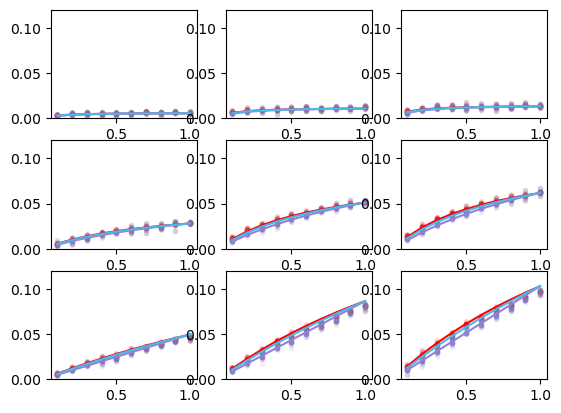

In [9]:
fig, ax = plt.subplots(3, 3)
col1 = '#FF0000'
col2 = '#9580D6'
col3 = '#4AB7ED'
for i in range(3):
    for j in range(3):
        s1 = sim_results[1][:,i,j,:,0].mean(-1)
        s2 = sim_results[1][:,i,j,:,2].mean(-1)
        s3 = sim_results[1][:,i,j,:,4].mean(-1)
        ax[i,j].plot(sim_results[0]['PR_G'], s1, '.', color=col1)
        ax[i,j].plot(sim_results[0]['PR_G'], s2, '.', color=col2)
        ax[i,j].plot(sim_results[0]['PR_G'], s3, '.', color=col3)
        for k in range(10):
            s1 = sim_results[1][:,i,j,k,0]
            s2 = sim_results[1][:,i,j,k,2]
            s3 = sim_results[1][:,i,j,k,4]
            ax[i,j].plot(sim_results[0]['PR_G'], s1, '.', alpha=0.1, color=col1)
            ax[i,j].plot(sim_results[0]['PR_G'], s2, '.', alpha=0.1, color=col2)
            ax[i,j].plot(sim_results[0]['PR_G'], s3, '.', alpha=0.1, color=col3)
        t1 = sim_results[1][:,i,j,:,1].mean(-1)
        t2 = sim_results[1][:,i,j,:,3].mean(-1)
        t3 = sim_results[1][:,i,j,:,5].mean(-1)
        ax[i,j].plot(sim_results[0]['PR_G'], t1, color=col1)
        ax[i,j].plot(sim_results[0]['PR_G'], t2, color=col2)
        ax[i,j].plot(sim_results[0]['PR_G'], t3, color=col3)
        ax[i,j].set_ylim([0, 0.12])

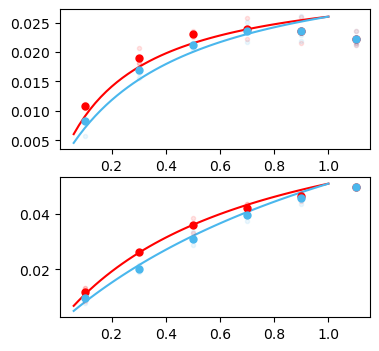

In [122]:
fig, ax = plt.subplots(2, 1, figsize=(4, 4))
col1 = '#FF0000'
col2 = '#4AB7ED'
for i_PRD in range(2):
    ax[i_PRD].plot(theory_results[0]['PR_G'], theory_results[1][:,i_PRD,0,1], color=col1)
    ax[i_PRD].plot(theory_results[0]['PR_G'], theory_results[1][:,i_PRD,0,3], color=col2)
    for k in range(3):
        pass
        ax[i_PRD].plot(sim_results[0]['PR_G'], sim_results[1][:,i_PRD,k,0], '.', color=col1, alpha=0.1, label='_nolegend_')
        ax[i_PRD].plot(sim_results[0]['PR_G'], sim_results[1][:,i_PRD,k,2], '.', color=col2, alpha=0.1, label='_nolegend_',
                       fillstyle='full')
    ax[i_PRD].plot(sim_results[0]['PR_G'], sim_results[1][:,i_PRD,:,0].mean(-1),'.', color=col1,
                   markersize=10, alpha=1, label='_nolegend_')
    ax[i_PRD].plot(sim_results[0]['PR_G'], sim_results[1][:,i_PRD,:,2].mean(-1),'.', color=col2,
               markersize=10, alpha=1, label='_nolegend_')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
col1 = '#FF0000'
col2 = '#4AB7ED'
for k in range(10):
    pass
    ax.plot(sim_results[0]['PR_G'], sim_results[1][:,0,0,k,0], '.', color=col1, alpha=0.1, label='_nolegend_')
    ax.plot(sim_results[0]['PR_G'], sim_results[1][:,0,0,k,2], '.', color=col2, alpha=0.1, label='_nolegend_',
            fillstyle='full')
ax.plot(sim_results[0]['PR_G'], sim_results[1][:,0,0,:,0].mean(-1),'.', color=col1,
        markersize=10, alpha=1, label='_nolegend_')
ax.plot(theory_results[0]['PR_G'], theory_results[1][:,0,0,0,1], color=col1)
ax.plot(sim_results[0]['PR_G'], sim_results[1][:,0,0,:,2].mean(-1), '.', color=col2,
        markersize=10, alpha=1, label='_nolegend_')
ax.plot(theory_results[0]['PR_G'], theory_results[1][:,0,0,0,3], color=col2)
ax.set_ylim([0, 0.12])
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
#ax.legend(['$PR(\{G_i \phi_i\})$ sim', '$PR(\{G_i \phi_i\})$ theory',
#           '$PR(\{\phi_i\})$ sim', '$PR(\{\phi_i\})$ theory'])
ax.legend(['$PR(\{\phi_i\})$', '$PR(\{G_i \phi_i\})$'],frameon=False)
ax.set_xlabel('$PR(\{G_i\})$')
ax.set_yticks([0, 0.03, 0.06])
#fig.savefig('figs/LDRG_PR_match_2.pdf')

In [ ]:
plt.figure()
for k in range(10):
    plt.plot(configs_array_1['PR_G'], results_array_1[:,k,0], '.', color='C0', alpha=0.1)
plt.plot(configs_array_1['PR_G'], results_array_1[:,:,0].mean(-1), '.', color='C0', markersize=10, alpha=1)
plt.plot(configs_array['PR_G'], results_array[:,0,1], color='k')
plt.ylim([0, 0.1])
plt.figure()
for k in range(10):
    plt.plot(configs_array_1['PR_G'], results_array_1[:,k,2], '.', color='C0', alpha=0.1)
plt.plot(configs_array_1['PR_G'], results_array_1[:,:,2].mean(-1), '.', color='C0', markersize=10, alpha=1)
plt.plot(configs_array['PR_G'], results_array[:,0,3], color='k')
plt.ylim([0, 0.1])

In [ ]:
from scipy.stats import bootstrap
mean_pr = results_array[:,:,0].mean(-1)
sem_pr = results_array[:,:,0].std(-1)/np.sqrt(10)
sem_pr = bootstrap((results_array[:,:,0],), np.mean, axis=1)
#plt.errorbar(configs_array['g'], mean_pr, yerr=sem_pr, color='C0')
plt.fill_between(configs_array['alpha'], sem_pr.confidence_interval.low,
                 sem_pr.confidence_interval.high)
for i_seed in range(10):
    pass
    #plt.plot(configs_array['g'], results_array[:,i_seed,0], '.', color='C0')
plt.plot(configs_array['alpha'], results_array[:,0,1], color='k')
plt.xscale('log')
#plt.ylim([0, 0.07])

In [ ]:
from scipy.stats import bootstrap
mean_pr = results_array[:,:,0].mean(-1)
sem_pr = results_array[:,:,0].std(-1)/np.sqrt(10)
sem_pr = bootstrap((results_array[:,:,0],), np.mean, axis=1)
#plt.errorbar(configs_array['g'], mean_pr, yerr=sem_pr, color='C0')
plt.fill_between(configs_array['PR_G'], sem_pr.confidence_interval.low,
                 sem_pr.confidence_interval.high)
for i_seed in range(10):
    pass
    #plt.plot(configs_array['g'], results_array[:,i_seed,0], '.', color='C0')
plt.plot(configs_array['PR_G'], results_array[:,0,1], color='k')
#plt.xscale('log')
#plt.ylim([0, 0.07])

In [ ]:
from scipy.stats import bootstrap
mean_pr = results_array[:,:,2].mean(-1)
sem_pr = results_array[:,:,2].std(-1)/np.sqrt(10)
sem_pr = bootstrap((results_array[:,:,2],), np.mean, axis=1)
#plt.errorbar(configs_array['g'], mean_pr, yerr=sem_pr, color='C0')
plt.fill_between(configs_array['PR_G'], sem_pr.confidence_interval.low,
                 sem_pr.confidence_interval.high)
for i_seed in range(10):
    pass
    #plt.plot(configs_array['g'], results_array[:,i_seed,0], '.', color='C0')
plt.plot(configs_array['PR_G'], results_array[:,0,3], color='k')

In [ ]:
from scipy.stats import bootstrap
mean_pr = results_array[:,:,0].mean(-1)
sem_pr = results_array[:,:,0].std(-1)/np.sqrt(10)
sem_pr = bootstrap((results_array[:,:,0],), np.mean, axis=1)
#plt.errorbar(configs_array['g'], mean_pr, yerr=sem_pr, color='C0')
plt.fill_between(configs_array['g'], sem_pr.confidence_interval.low,
                 sem_pr.confidence_interval.high)
for i_seed in range(10):
    pass
    #plt.plot(configs_array['g'], results_array[:,i_seed,0], '.', color='C0')
plt.plot(configs_array['g'], results_array[:,0,1], color='k')
plt.ylim([0, 0.07])